Assignment 9: Convolutional Auto-Encoder
========================================


Microsoft Forms Document: https://forms.office.com/r/ugv3L3jv8i

The task of this assignment is to compute a valuable deep feature representation for the handwritten digits of the MNIST dataset, without making use of their labels.
For this purpose, we implement a convolutional auto-encoder that learns a $K=10$-dimensional deep feature representation of each digit.
This representation can then be used to reconstruct images using the decoder part.

Task 1: Datasets
----------------

We will make use of the default implementations of the MNIST dataset.
As usual, we will need the training and validation set splits of MNIST, including data loaders.
The batches of the training set should be of size $B=32$, validation set batches should contain 100 samples.


In [1]:
import torch
import torchvision

# training set and data loader
train_set =  torchvision.datasets.MNIST(
  root=".",
  train=True,
  download=True,
  transform=torchvision.transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=32)

# validation set and data loader
validation_set = torchvision.datasets.MNIST(root="",
  train=False,
  download=True,
  transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=100)

Task 2: Encoder Network
-----------------------

For the encoder network, we will rely on a similar implementation from the last exercise, which is a convolutional network with two convolutional and one fully-connected layers.
The output of the encoder network determines the deep feature representation, which we will define to be $K=10$-dimensional.

There is one main difference to the network from Assignment 8, which is the way we perform our down sampling.
Instead of choosing a maximum pooling layer, we use a stride of 2 in our convolutions.
The ReLU activation function should be applied after each convolution.

In [2]:
class Encoder (torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    # call base class constrcutor
    super(Encoder,self).__init__()
    # convolutional define layers
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size=5, stride=2, padding=2)
    self.conv2 = torch.nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size=5, stride=2, padding=2)
    # activation functions will be re-used for the different stages
    self.act = torch.nn.ReLU()

    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    self.fc = torch.nn.Linear(in_features=int(Q2*28*28*0.5**2*0.5**2),out_features=K, bias=True)

  def forward(self, x):
    # get the deep feature representation
    x = self.conv1(x)
    x = self.act(x)
    x = self.conv2(x)
    x = self.act(x)
    x = self.flatten(x)
    deep_feature = self.fc(x)
    return deep_feature

Task 3: Decoder Network
-----------------------

The decoder network will obtain a deep feature representation as resulting from the encoder network.
It will learn to undo all the steps from the encoder, in order to produce an image that is of comparable size as the original images.
For this purpose, we require our decoder network to have:

* one fully-connected layer that produces the same number of outputs as are the input of the fully-connected layer of the encoder
* we apply the ReLU activation function
* then, the batch must be reshaped to the same dimensionality as the output of the `conv2` layer of the encoder
* we apply a fractionally-strided convolution using the `torch.nn.ConvTranspose2d` that uses the same parameters as the `conv2` layer of the encoder; you might need to adapt the `output_padding`
* we apply the ReLU activation function
* we apply a fractionally-strided convolution using the same parameters as the `conv1` layer of the encoder; `output_padding` might be required to be applied

Finally, the goal is to have the output to be restricted between 0 and 1.
Think of possible ways of doing that, and apply the way that seems most reasonable.

Implement a network class that provides the required functionality.
Implement both a constructor `__init__` and a `forward` function.


In [3]:
class Decoder (torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    # call base class constrcutor
    super(Decoder,self).__init__()
    # fully-connected layer
    self.fc = torch.nn.Linear(in_features=K, out_features=7*7*Q2, bias=True)
    # convolutional layers
    self.deconv1 = torch.nn.ConvTranspose2d(in_channels=Q2, out_channels=Q1, kernel_size=5, stride=2, padding=2, output_padding=1)
    self.deconv2 = torch.nn.ConvTranspose2d(in_channels=Q1, out_channels=1, kernel_size=5, stride=2, padding=2, output_padding=1)
    # activation function
    self.act = torch.nn.ReLU()
    # unflatten
    self.unflatten = torch.nn.Unflatten(dim=1, unflattened_size=(Q2,7,7))

  def forward(self, x):
    # reconstruct the output image
    a = self.unflatten(self.act(self.fc(x))) # (B,Q2,7,7)
    # compute first layer of deconvolution and activation
    a = self.act(self.deconv1(a)) # (B, Q2, 14, 14)
    # compute second layer of deconvolution and activation
    a = self.deconv2(a) # (B, Q1, 28, 28)
    output = (a-torch.min(a))/(torch.max(a)-torch.min(a))
    return output

Task 4: Joint Auto-Encoder Network
-----------------------------------

Implement an auto-encoder network that includes bot the encoder and the decoder.
Implement both a constructor `__init__` and a `forward` function.


In [4]:
class AutoEncoder(torch.nn.Module):
  def __init__(self, Q1, Q2, K):
    super(AutoEncoder,self).__init__()
    self.encoder = Encoder(Q1, Q2, K)
    self.decoder = Decoder(Q1, Q2, K)

  def forward(self,x):
    # encode input
    deep_feature = self.encoder(x)
    # decode to output
    reconstructed = self.decoder(deep_feature)
    return reconstructed

Test 1: Output Sizes
--------------------

Instantiate the auto-encoder network with $Q_1 = 32$, $Q_2 = 32$ and $K=10$.
Create an input $\mathbf X$ in the size that the `AutoEncoder` network requires.
Provide that input to the (untrained) encoder part of the auto-encoder network to extract the deep feature representation.
Check that the deep feature is in the desired size (K=10) 
Provide the deep feature to the (untrained) decoder part of the auto-encoder network.
Check that the output is of dimension $28\times28$, and its values are between 0 and 1.

In [5]:
# run on cuda device?
device = torch.device("cuda")
# create network
network = AutoEncoder(32, 32, 10)

# create or select a sample
sample,_ = next(iter(train_loader))
# use encoder to encode image and check its size
e_sample = network.encoder(sample)
assert e_sample.shape[1] == 10

# use decoder to generate an image and check its size and value range
assert network.decoder(e_sample).shape[1] == 1
assert network.decoder(e_sample).shape[2] == 28
assert network.decoder(e_sample).shape[3] == 28

Task 5: Training Loop
---------------------

To train the auto-encoder network, we will use the $L_2$ distance between the output and the input of the network as a loss function.
This loss function is implemented in `torch.nn.MSELoss`.

Since training an auto-encoder is tricky, we will make use of the Adam optimizer.
Choose a learning rate of $\eta=0.001$.

Implement the training loop for 10 epochs.
Compute the average training loss and validation loss and print them at the end of each epoch.

Note: If the training and validation loss do not decrease during training, try to reduce the learning rate (to $\eta=0.0005$ or even lower) and re-start the training.
You will need to re-initialize the network, too, i.e. by re-running the previous cell.

In [6]:
# Adam optimizer with appropriate learning rate
optimizer = torch.optim.Adam(network.parameters(), lr=0.0005, weight_decay=1e-05)
loss = torch.nn.MSELoss()
# instantiate the correct device
device = torch.device("cuda")
network = network.to(device)

for epoch in range(10):
  # evaluate average loss for training and validation set
  train_loss = validation_loss = 0.

  for x,_ in train_loader:
    optimizer.zero_grad()
    # compute network output
    x = x.to(device)
    y = network(x)
    # compute loss between output and input
    J = loss(y,x)
    # perform update
    J.backward()
    optimizer.step()
    # accumulate loss
    train_loss += J.item()

  # compute validation loss
  with torch.no_grad():
    for x,t in validation_loader:
      x = x.to(device)
      # compute network output
      y = network(x)
      # compute loss
      J = loss(y,x)
      # accumulate loss
      validation_loss += J

  # print average loss for training and validation
  print(f"\rEpoch {epoch}; train: {train_loss/len(train_set):1.5f}, val: {validation_loss/len(validation_set):1.5f}")

Epoch 0; train: 0.00139, val: 0.00033
Epoch 1; train: 0.00095, val: 0.00028
Epoch 2; train: 0.00085, val: 0.00026
Epoch 3; train: 0.00079, val: 0.00024
Epoch 4; train: 0.00074, val: 0.00023
Epoch 5; train: 0.00071, val: 0.00022
Epoch 6; train: 0.00069, val: 0.00022
Epoch 7; train: 0.00067, val: 0.00021
Epoch 8; train: 0.00065, val: 0.00020
Epoch 9; train: 0.00063, val: 0.00020


Task 6: Reconstruction Result
-----------------------------

Now we want to see if we can reconstruct images from their originals.
For this purpose, we select the first batch of our validation set images that contains 100 samples.
We forward this batch through our auto-encoder network and plot the reconstructed samples next to the original samples.

We will plot all the samples into a single plot, where we have 10 rows, each of which containing 10 pairs of original and reconstructed samples.

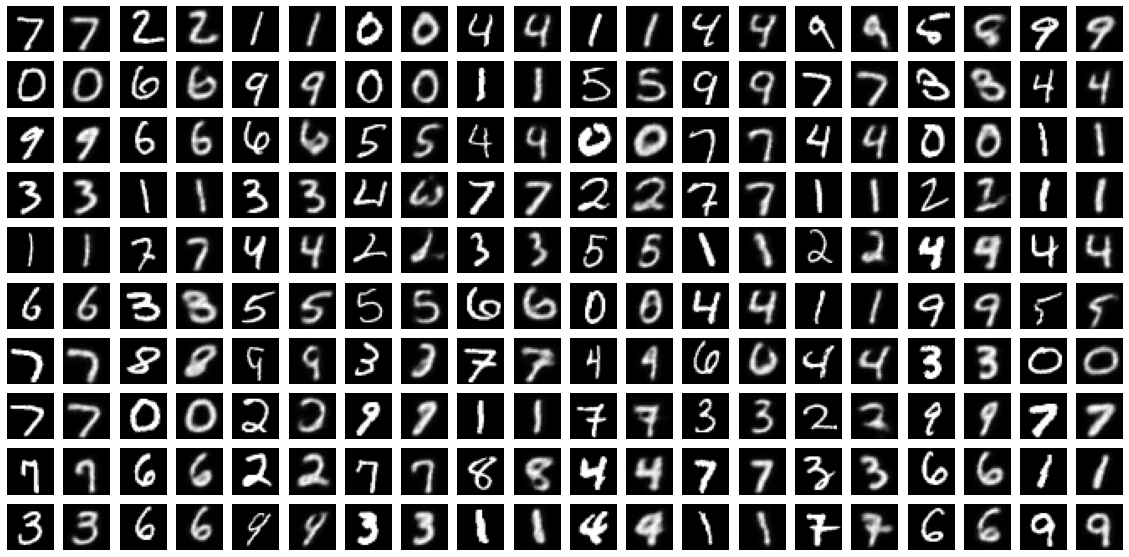

In [7]:
# get first validation set batch
input, _ = next(iter(validation_loader))

# compute outputs for all samples
output = network(input.to(device)).cpu().detach().numpy()

# plot images
from matplotlib import pyplot
pyplot.rcParams['image.cmap'] = 'gray'

pyplot.figure(figsize = (20,10))
for i in range(10):
  for j in range(10):
    pyplot.subplot(10, 20, i*20+2*j+1)
    pyplot.imshow(input[i * 10 + j][0])
    pyplot.axis("off")
    pyplot.subplot(10, 20, i*20+2*j+2)
    pyplot.imshow(output[i * 10 + j][0])
    pyplot.axis("off")

Task 7: Mean Vector per Class
-----------------------------

To see if the network has learned a reasonable representation for our 10 digits, we extract the mean deep feature vectors for each of the 10 classes.
We forward all samples of our validation set through the encoder part of our trained auto-encoder network, and compute a class-wise average of the deep features.

In [8]:
total_sum_features = torch.zeros(10,10).to(device)
count = torch.zeros(10).to(device)

with torch.no_grad():
  # compute means
  for x, t in validation_loader:
    # extract deep features from encoder
    deep_features = network.encoder.forward(x.to(device))
    # accumulate deep features for each class
    for idx, ft in enumerate(deep_features):
      count[t[idx]] += 1
      total_sum_features[t[idx]] += ft

# compute means
means = total_sum_features/count
assert means.shape == (10, 10)

Task 8: Decode Mixtures of Classes
----------------------------------

For each pair of class indexes, we compute the average of the deep feature representations of these two classes.
This results in a total of $10*10=100$ deep feature representations.

We use the decoder part of our trained auto-encoder network to reconstruct images from the deep feature representations.
We plot them in a grid of size $10*10$.
Note that the diagonal represents the reconstruction of the mean deep features for all classes, while non-diagonal elements show mixtures of two classes.

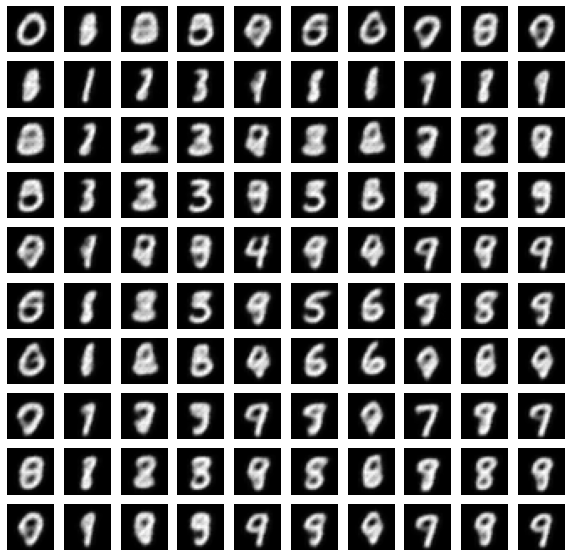

In [9]:
# compute mixtures of each two classes  
mixtures = torch.zeros((10,10,10,), device=device)

for o1 in range(10):
  for o2 in range(10):
    mixtures[o1,o2]=((means[o1]+means[o2])/2)

# use network decoder to generate images
mixtures = torch.reshape(mixtures, (100,10))
images = network.decoder(mixtures)
images = torch.squeeze(images).cpu()

# and plot
pyplot.figure(figsize=(10,10))
for o1 in range(10):
  for o2 in range(10):
    pyplot.subplot(10,10,o1*10+o2+1)
    pyplot.imshow(images[o1*10+o2].detach().numpy())
    pyplot.axis("off")